In [2]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from linearmodels import PooledOLS

In [3]:
sin_portfolio_df = pd.read_csv("sin_portfolio_returnsV2.csv")

other_factors_df = pd.read_csv("final_merged.csv")

# Converting data types for merging

In [4]:
sin_portfolio_df["Date"] = pd.to_datetime(sin_portfolio_df["Date"])
sin_portfolio_df.set_index("Date", inplace=True)
sin_portfolio_df.head()

,Num_Active_Stocks,BEAM,BEER,PFB,ABW,GBL,RUP,CNB,CKB,FAL,...,CEDC,PTT,Portfolio_Returns,Portfolio_Proportion,Unnamed: 97,Risk_Free_Percent,Risk_Free_Decimal,Risk_Free_Monthly,Unnamed: 101,Excess_Return
Date,,,,,,,,,,,,,,,,,,,,,
1962-08-31,19,NaN,NaN,0.005013,NaN,0.005263,0.000248,0.003096,NaN,-0.000405,...,NaN,NaN,-0.028063,0.052632,NaN,3.98,0.0398,0.000274,NaN,-0.02833753
1962-09-30,19,NaN,NaN,-0.002288,NaN,-0.009569,-0.002471,-0.002924,NaN,-0.003672,...,NaN,NaN,7.390793,0.052632,NaN,3.98,0.0398,0.000274,NaN,7.390518496
1962-10-31,19,NaN,NaN,-0.007177,NaN,-0.023392,-0.004148,0.003096,NaN,-0.002193,...,NaN,NaN,-0.095336,0.052632,NaN,3.93,0.0393,0.000271,NaN,-0.095606439
1962-11-30,17,NaN,NaN,NaN,NaN,NaN,0.001258,0.004085,NaN,0.004859,...,NaN,NaN,0.044245,0.058824,NaN,3.92,0.0392,0.000270,NaN,0.043974828
1962-12-31,18,NaN,NaN,NaN,0.0,NaN,0.000873,0.002165,NaN,-0.001562,...,NaN,NaN,2.401140,0.055556,NaN,3.86,0.0386,0.000266,NaN,2.400873839


In [5]:
other_factors_df.rename(columns = {"Unnamed: 0": "Date", "Excess Return on the Market": "ExRm"}, inplace = True)
other_factors_df["Date"] = pd.to_datetime(other_factors_df["Date"])
other_factors_df.set_index("Date", inplace=True)
other_factors_df.head()

,ABEV,ABUD,ABV,ABW,ACCOB,ADC,ADSO,AED,AFTI,BACA,...,VO,FARM,GMCR,JVA,PEET,ExRm,SMB,HML,MOM,USREC
Date,,,,,,,,,,,,,,,,,,,,,
1962-07-31,NaN,NaN,NaN,NaN,NaN,37.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0628,0.0163,-0.0357,0.0055,0
1962-08-31,NaN,NaN,NaN,NaN,NaN,37.250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0213,0.0125,-0.0121,-0.0058,0
1962-09-30,NaN,NaN,NaN,NaN,NaN,37.250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.0522,-0.0248,0.0134,0.0395,0
1962-10-31,NaN,NaN,NaN,NaN,NaN,33.375,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.0005,-0.0401,0.0135,0.0075,0
1962-11-30,NaN,NaN,NaN,2.5,NaN,39.625,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.1087,0.0259,0.0099,-0.0717,0


# Filtering required columns only

In [6]:
sin_portfolio_df = sin_portfolio_df[["Portfolio_Returns"]]
other_factors_df = other_factors_df[["ExRm", "SMB", "HML", "MOM", "USREC"]]


# Merging for model building

## Checking shapes before merging

In [7]:
sin_portfolio_df.shape, other_factors_df.shape

((701, 1), (702, 5))

In [41]:
model_df = pd.concat([sin_portfolio_df, other_factors_df], axis = 1, join = "inner")

model_df.rename(columns = {"Portfolio_Returns": "Portfolio_Excess_Return"}, inplace=True)
model_df

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
1962-08-31,-0.028063,0.0213,0.0125,-0.0121,-0.0058,0
1962-09-30,7.390793,-0.0522,-0.0248,0.0134,0.0395,0
1962-10-31,-0.095336,-0.0005,-0.0401,0.0135,0.0075,0
1962-11-30,0.044245,0.1087,0.0259,0.0099,-0.0717,0
1962-12-31,2.401140,0.0101,-0.0380,0.0035,0.0588,0
...,...,...,...,...,...,...
2020-08-31,-0.132603,0.0763,-0.0022,-0.0293,0.0051,0
2020-09-30,9.329493,-0.0363,-0.0004,-0.0266,0.0305,0
2020-10-31,-0.116476,-0.0210,0.0439,0.0419,-0.0303,0


# Exploratory Data Analysis

<AxesSubplot:xlabel='Date'>

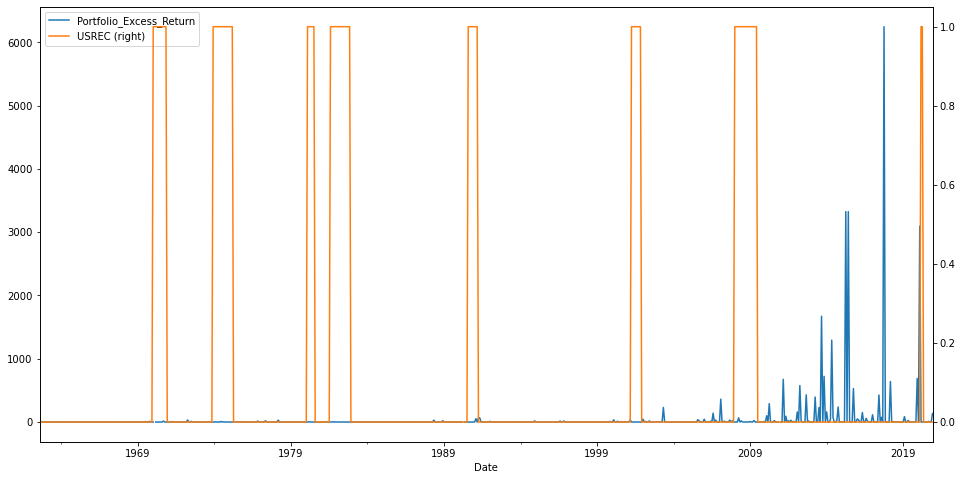

In [42]:
model_df[["Portfolio_Excess_Return", "USREC"]].plot(secondary_y = ["USREC"], figsize = (16,8))

We see abnormal spikes in the portfolio excess return. Upon closer inspection, there are INF values in sin portfolio returns

In [43]:
model_df[model_df["Portfolio_Excess_Return"] == np.inf]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
1970-02-28,inf,0.0513,-0.0256,0.0393,0.0012,1
1990-04-30,inf,-0.0336,-0.0045,-0.0259,0.0243,0
2010-12-31,inf,0.0682,0.0067,0.0378,-0.0318,0


In [44]:
model_df[model_df["Portfolio_Excess_Return"] == -np.inf]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,


## Replacing INF values with 0 (TEMPORARY FIX)

In [45]:
model_df.replace([np.inf, -np.inf], 0, inplace=True)

In [46]:
model_df[model_df["Portfolio_Excess_Return"] == np.inf]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,


# Replotting

<AxesSubplot:xlabel='Date'>

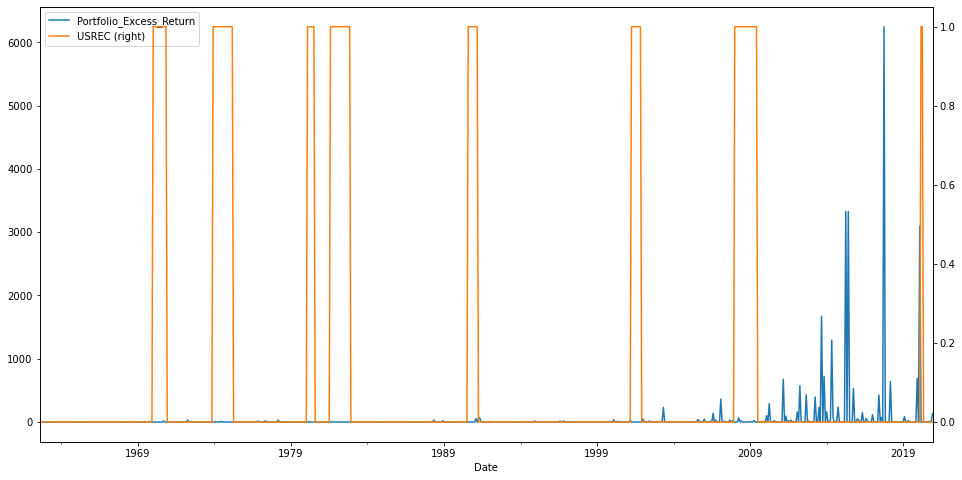

In [47]:
model_df[["Portfolio_Excess_Return", "USREC"]].plot(secondary_y = ["USREC"], figsize = (16,8))

In [48]:
model_df.describe()

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,40.133655,0.005855,0.001956,0.002618,0.006360,0.121255
std,332.990403,0.044649,0.030420,0.028446,0.041981,0.326657
min,-0.215271,-0.232400,-0.172900,-0.140200,-0.343900,0.000000
25%,-0.035578,-0.019600,-0.016500,-0.013700,-0.009100,0.000000
50%,0.013545,0.009300,0.001400,0.002700,0.007100,0.000000
75%,0.125168,0.034400,0.020300,0.016900,0.028900,0.000000
max,6246.586886,0.161000,0.214800,0.124800,0.183600,1.000000


### Checking periods where Portfolio_Excess_Return > 100%

In [49]:
model_df[model_df["Portfolio_Excess_Return"] > 100]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
2003-05-31,230.037740,0.0605,0.0471,0.0053,-0.1085,0
2006-08-31,139.720510,0.0203,0.0101,-0.0204,-0.0346,0
2007-02-28,360.898297,-0.0196,0.0118,-0.0012,-0.0136,0
2010-04-30,289.922723,0.0200,0.0487,0.0289,0.0321,0
2011-03-31,674.675380,0.0046,0.0256,-0.0188,0.0352,0
2012-02-29,158.799935,0.0442,-0.0186,0.0043,-0.0028,0
2012-04-30,575.486483,-0.0085,-0.0041,-0.0077,0.0383,0
2012-09-30,429.370161,0.0273,0.0054,0.0158,-0.0106,0
2013-04-30,394.722372,0.0155,-0.0236,0.0050,0.0027,0


Upon rechecking the price data, some stocks have extremely volatile price movements (e.g. STZ), resulting in extremely high jumps in portfolio returns

### Checking periods of negative Portfolio REturns

In [50]:
model_df[model_df["Portfolio_Excess_Return"] < 0]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
1962-08-31,-0.028063,0.0213,0.0125,-0.0121,-0.0058,0
1962-10-31,-0.095336,-0.0005,-0.0401,0.0135,0.0075,0
1963-02-28,-0.016824,-0.0238,0.0046,0.0220,0.0252,0
1963-03-31,-0.009285,0.0308,-0.0248,0.0190,0.0156,0
1963-04-30,-0.047474,0.0451,-0.0135,0.0100,-0.0008,0
...,...,...,...,...,...,...
2020-01-31,-0.215271,-0.0011,-0.0313,-0.0624,0.0543,0
2020-03-31,-0.148331,-0.1338,-0.0489,-0.1402,0.0854,1
2020-05-31,-0.089219,0.0558,0.0245,-0.0480,0.0067,0


# Model Building
https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

In [51]:
model_df2 = model_df.copy()

# model_df2["Time_Dummy"] = np.arange(len(model_df.index))
model_df2

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
1962-08-31,-0.028063,0.0213,0.0125,-0.0121,-0.0058,0
1962-09-30,7.390793,-0.0522,-0.0248,0.0134,0.0395,0
1962-10-31,-0.095336,-0.0005,-0.0401,0.0135,0.0075,0
1962-11-30,0.044245,0.1087,0.0259,0.0099,-0.0717,0
1962-12-31,2.401140,0.0101,-0.0380,0.0035,0.0588,0
...,...,...,...,...,...,...
2020-08-31,-0.132603,0.0763,-0.0022,-0.0293,0.0051,0
2020-09-30,9.329493,-0.0363,-0.0004,-0.0266,0.0305,0
2020-10-31,-0.116476,-0.0210,0.0439,0.0419,-0.0303,0


In [52]:
X = model_df2[["ExRm", "SMB", "HML", "MOM"]]
y = model_df2["Portfolio_Excess_Return"]

X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Portfolio_Excess_Return   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                 -0.005
Method:                      Least Squares   F-statistic:                    0.1499
Date:                     Thu, 28 Jul 2022   Prob (F-statistic):              0.963
Time:                             20:33:23   Log-Likelihood:                -5065.4
No. Observations:                      701   AIC:                         1.014e+04
Df Residuals:                          696   BIC:                         1.016e+04
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.1876     13.102      3.220      0.001      16.463      67.912
ExRm        -103.4773    307.809     -0.336      0.737    -707.822     500.867
SMB          -34.9013    438.215     -0.080      0.937    -895.282     825.480
HML         -354.7767    472.138     -0.751      0.453   -1281.762     572.208
MOM          -70.8892    315.165     -0.225      0.822    -689.677     547.898
==============================================================================
Omnibus:                     1337.241   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1290120.540
Skew:                          13.409   Prob(JB):                         0.00
Kurtosis:                     211.448   Cond. No.                         39.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""